In [1]:
import pandas as pd
import numpy as np
import umap
import hdbscan
from sklearn.metrics import silhouette_score
import itertools
from joblib import Parallel, delayed
# Custom Helper Functions
from helper_functions import print_boxed_text, save_boxed_text_to_file, phi_coefficient, one_hot_encode, standardize_numeric

import numpy as np
import umap
import hdbscan
from sklearn.metrics import silhouette_score
import itertools

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
DATA = pd.read_csv("/Users/leo/Programming/PLR/Leo/data/dataset_3.csv").drop(columns=["Unnamed: 0"])

In [3]:
# Search space

# Define thresholds
skew_thresholds = [0.5, 0.6, 0.7, 0.8]
phi_thresholds = [0.3, 0.4, 0.5, 0.6]

# Define UMAP and HDBSCAN parameters
umap_params = [
    {'n_neighbors': n, 'min_dist': d}
    for n in [5, 10, 15, 20]
    for d in [0.0, 0.1, 0.2, 0.3]
]

hdbscan_params = [
    {'min_cluster_size': s, 'min_samples': m}
    for s in [5, 10, 15, 20]
    for m in [1, 5, 10, 15]
]

In [4]:
#Drop skewed features
def drop_skewed_features(df, threshold=0.5):
    """
    Drop features that are skewed towards 0 or 1.
    
    Parameters:
        df (DataFrame): The input DataFrame with binary features.
        threshold (float): The skewness threshold. Features with skewness above this value will be dropped.
        
    Returns:
        DataFrame: A new DataFrame with skewed features removed.
    """
    lines = ["Dropped Skewed Features"]
    is_title = [True]
    
    dropped_features = []
    
    for col in df.columns:
        # Calculate the skewness for each feature
        skewness = df[col].mean()
        
        # Check if the feature is skewed towards 0 or 1
        if skewness > threshold or skewness < (1 - threshold):
            line = f"Dropping {col} with skewness {skewness:.4f}"
            lines.append(line)
            is_title.append(False)
            dropped_features.append(col)
            
    # Drop the skewed features
    df_dropped = df.drop(columns=dropped_features)
    
    return df_dropped


In [5]:
def drop_correlated_features(df, threshold=0.4):
    """
    Drop highly correlated features based on phi coefficient.

    Parameters:
        df (DataFrame): The input DataFrame with binary features.
        threshold (float): The phi coefficient threshold. Pairs of features with a phi coefficient above this value will be considered for dropping.

    Returns:
        DataFrame: A new DataFrame with highly correlated features removed.
    """
    # Initialize an empty dataframe to store phi values
    phi_values = pd.DataFrame(index=df.columns, columns=df.columns)

    # Calculate phi values
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 >= col2:  # Avoid duplicate calculations
                continue
            contingency_table = pd.crosstab(df[col1], df[col2])
            phi = phi_coefficient(contingency_table)
            phi_values.loc[col1, col2] = phi
            phi_values.loc[col2, col1] = phi  # Symmetric matrix

    # Convert to float
    phi_values = phi_values.astype(float)

    # Identify columns to drop
    to_drop = set()
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2 or col1 in to_drop or col2 in to_drop:
                continue
            phi_value = abs(phi_values.loc[col1, col2])
            if phi_value > threshold:
                to_drop.add(col1)  # Choose one column from the pair to drop

    # Drop the highly correlated columns
    df_dropped = df.drop(columns=to_drop)

    return df_dropped


In [6]:
import itertools
import numpy as np
import umap
import hdbscan
from sklearn.metrics import silhouette_score

# Function to preprocess data
def preprocess_data(df, skew_threshold, corr_threshold):
    df_unskewed = drop_skewed_features(df, skew_threshold)
    df_drop_corr = drop_correlated_features(df_unskewed, corr_threshold)
    return df_drop_corr

def cluster_and_evaluate(data, skew_threshold, corr_threshold, umap_params, hdbscan_params):
    preprocessed_data = preprocess_data(data, skew_threshold, corr_threshold)
    if preprocessed_data.empty:
        print("Preprocessed data is empty. Skipping this iteration.")
        return -1, 0

    umap_model = umap.UMAP(**umap_params, random_state=42)
    try:
        data_umap = umap_model.fit_transform(preprocessed_data)
    except ValueError as e:
        print(f"Error during UMAP transformation: {e}")
        return -1, 0

    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    cluster_labels = clusterer.fit_predict(data_umap)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    if 5 <= n_clusters <= 10:
        score = silhouette_score(data_umap, cluster_labels)
        return score, n_clusters
    else:
        return -1, n_clusters

# Define the parameter grid
skew_thresholds = [0.7, 0.75, 0.8, 0.85, 0.9]
corr_thresholds = [0.5, 0.6, 0.7]
umap_params = [{'n_neighbors': n, 'min_dist': d} for n in [5, 10, 15, 20] for d in [0.0, 0.1, 0.2, 0.3]]
hdbscan_params = [{'min_cluster_size': s, 'min_samples': m} for s in [5, 10, 15, 20] for m in [1, 5, 10, 15]]

# Grid search
best_score = -1
best_params = None
best_cluster_number = None

for skew_threshold, corr_threshold in itertools.product(skew_thresholds, corr_thresholds):
    for umap_param_values, hdbscan_param_values in itertools.product(umap_params, hdbscan_params):
        score, n_clusters = cluster_and_evaluate(DATA, skew_threshold, corr_threshold, umap_param_values, hdbscan_param_values)
        print(f"Silhouette Score: {score:.4f} | Number of Clusters: {n_clusters} | Skew Threshold: {skew_threshold} | Corr Threshold: {corr_threshold} | UMAP Params: {umap_param_values} | HDBSCAN Params: {hdbscan_param_values}")
        if score > best_score:
            best_score = score
            best_params = (skew_threshold, corr_threshold, umap_param_values, hdbscan_param_values)
            best_cluster_number = n_clusters

# Output the best parameters and score
print(f"Best Silhouette Score: {best_score}")
print(f"Best Skew Threshold: {best_params[0]}")
print(f"Best Correlation Threshold: {best_params[1]}")
print(f"Best UMAP Parameters: {best_params[2]}")
print(f"Best HDBSCAN Parameters: {best_params[3]}")
print(f"Number of Clusters: {best_cluster_number}")


In [ ]:
import pandas as pd

# Load the groupings
groupings_path = '/Users/leo/Programming/PLR/Leo/data/symptom_groups.csv'
symptom_groups = pd.read_csv(groupings_path)

# Create a dictionary from the symptom groups
group_dict = dict(zip(symptom_groups['symptom'], symptom_groups['group']))

def aggregate_columns(data, group_dict):
    aggregated_data = pd.DataFrame()

    # Iterate over each column in the DataFrame
    for col in data.columns:
        if col.startswith('Grouped'):
            # Keep 'Grouped' columns as they are
            aggregated_data[col] = data[col]
        elif col in group_dict:
            # Aggregate columns based on their group
            group_name = group_dict[col]
            if group_name not in aggregated_data:
                aggregated_data[group_name] = data[col]
            else:
                aggregated_data[group_name] += data[col]
        else:
            # For columns not in the group_dict, add them as is
            aggregated_data[col] = data[col]

    # Compute the average for each group
    for group in set(group_dict.values()):
        if group in aggregated_data:
            aggregated_data[group] /= len([col for col in group_dict if group_dict[col] == group])

    return aggregated_data

# Aggregate the columns
dataset_aggregated = aggregate_columns(dataset_4_drop_corr, group_dict)

dataset_aggregated

,Memory,Cognitive,Auditory,Headaches,Olfaction,Sensory,Sleep,Temperature,Motor,Cardiac,...,Respiratory,Allergic,Vision,Skin,Musculoskeletal,Physical_PEM_Severity,FAS_cat_Minimal/No Fatigue,HasPeriods_Yes,Demographics_Age_Cleaned_40-49,cluster
0,0.0,0.2,0.000000,0.0,0.000,0.000000,0.1,0.250,0.00,0.2,...,0.125,0.000000,0.000000,0.00,0.25,0.5,1,0,0,104
1,0.2,0.2,0.222222,0.3,0.000,0.111111,0.2,0.250,0.25,0.2,...,0.250,0.000000,0.166667,0.00,0.25,0.9,0,0,1,-1
2,0.0,0.2,0.000000,0.0,0.000,0.222222,0.2,0.125,0.00,0.2,...,0.125,0.000000,0.000000,0.00,0.50,0.8,1,0,1,98
3,0.0,0.1,0.111111,0.3,0.250,0.333333,0.3,0.500,0.00,0.4,...,0.250,0.000000,0.000000,0.00,0.50,0.7,1,1,1,-1
4,0.0,0.1,0.111111,0.0,0.000,0.333333,0.2,0.500,0.25,0.4,...,0.250,0.111111,0.083333,0.00,0.25,1.0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,0.2,0.2,0.222222,0.4,0.000,0.111111,0.3,0.250,0.00,0.4,...,0.125,0.000000,0.250000,0.25,0.50,0.8,0,0,0,7
6027,0.2,0.2,0.111111,0.0,0.000,0.111111,0.1,0.000,0.00,0.4,...,0.250,0.000000,0.000000,0.00,0.00,1.0,0,0,0,72
6028,0.2,0.1,0.111111,0.3,0.000,0.111111,0.3,0.625,0.25,0.2,...,0.375,0.111111,0.083333,0.00,0.50,0.8,0,1,0,4
6029,0.0,0.0,0.000000,0.0,0.125,0.000000,0.2,0.000,0.00,0.0,...,0.000,0.000000,0.250000,0.00,0.00,0.0,1,0,0,87


/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_52506/1801541149.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_averages[f'Cluster {label}'] = cluster_avg
/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_52506/1801541149.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_averages[f'Cluster {label}'] = cluster_avg
/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_52506/1801541149.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

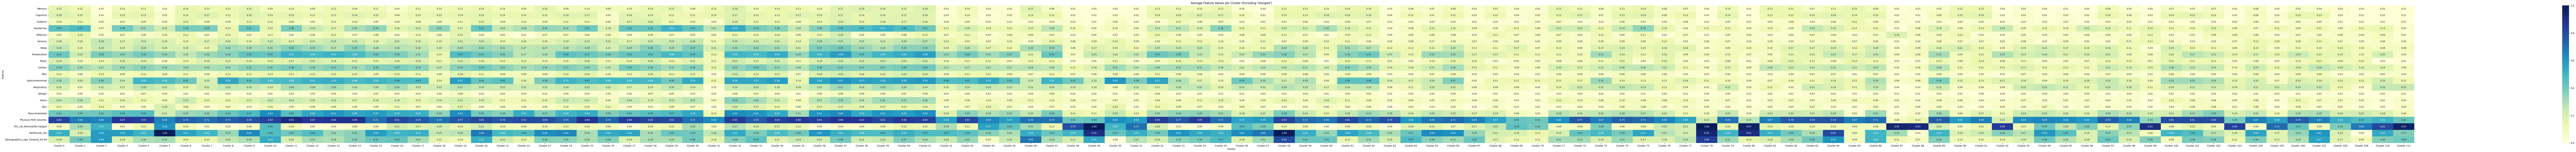

In [ ]:
import seaborn as sns

def plot_cluster_averages(data, cluster_labels):
    cluster_averages = pd.DataFrame()

    for label in np.unique(cluster_labels):
        if label == -1:  # Skip noise points
            continue

        cluster_data = data[data['cluster'] == label]

        # Exclude 'Grouped' columns
        filtered_data = cluster_data[[col for col in cluster_data.columns if not col.startswith('Grouped')]]

        # Exclude the 'Cluster' column
        filtered_data = filtered_data.drop('cluster', axis=1)

        cluster_avg = filtered_data.mean()
        cluster_averages[f'Cluster {label}'] = cluster_avg

    # Plotting the heatmap
    plt.figure(figsize=(len(cluster_averages.columns) * 2, len(cluster_averages.index) * 0.5))
    sns.heatmap(cluster_averages, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Average Feature Values per Cluster (Excluding 'Grouped')")
    plt.ylabel("Feature")
    plt.xlabel("Cluster")
    plt.show()

# Example usage of the function
plot_cluster_averages(dataset_aggregated, dataset_4_drop_corr['cluster'])

In [ ]:
import pandas as pd
import numpy as np

def cluster_averages_table(data, cluster_labels):
    unique_labels = np.unique(cluster_labels)
    unique_labels = unique_labels[unique_labels != -1]  # Exclude noise points

    # Prepare a DataFrame to store the averages
    cluster_averages = pd.DataFrame()

    for label in unique_labels:
        # Filter the data for each cluster
        cluster_data = data[data['cluster'] == label]

        # Filter out 'Grouped' columns and the 'cluster' column
        filtered_columns = [col for col in cluster_data.columns if not col.startswith('Grouped') and col != 'cluster']
        cluster_data = cluster_data[filtered_columns]

        # Calculate the mean and add it to the DataFrame
        cluster_avg = cluster_data.mean()
        cluster_averages[f'Cluster {label}'] = cluster_avg

    # Transpose the DataFrame for better readability
    cluster_averages = cluster_averages.transpose()

    # Optionally, sort the columns if needed
    # cluster_averages = cluster_averages.sort_values(by='some_column', ascending=False)

    return cluster_averages

# Example usage of the function
cluster_avg_table = cluster_averages_table(dataset_aggregated, dataset_4_drop_corr['cluster'])
print(cluster_avg_table)


               Memory  Cognitive  Auditory  Headaches  Olfaction   Sensory  \
Cluster 0    0.152000   0.178000  0.097778   0.438000   0.072500  0.180000   
Cluster 1    0.120000   0.150000  0.111111   0.470000   0.137500  0.155556   
Cluster 2    0.007407   0.025926  0.049383   0.070370   0.046296  0.255144   
Cluster 3    0.097436   0.146154  0.074074   0.397436   0.073718  0.170940   
Cluster 4    0.111111   0.151852  0.086420   0.307407   0.055556  0.213992   
...               ...        ...       ...        ...        ...       ...   
Cluster 107  0.043478   0.134783  0.048309   0.113043   0.054348  0.115942   
Cluster 108  0.028571   0.028571  0.010582   0.064286   0.062500  0.074074   
Cluster 109  0.000000   0.013636  0.015152   0.109091   0.056818  0.050505   
Cluster 110  0.018182   0.018182  0.010101   0.136364   0.090909  0.060606   
Cluster 111  0.009677   0.011290  0.012545   0.035484   0.024194  0.041219   

                Sleep  Temperature     Motor   Cardiac  ...  \


/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_52506/995045841.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_averages[f'Cluster {label}'] = cluster_avg
/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_52506/995045841.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_averages[f'Cluster {label}'] = cluster_avg
/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_52506/995045841.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_averages(data, cluster_labels):
    unique_labels = np.unique(cluster_labels)
    unique_labels = unique_labels[unique_labels != -1]  # Exclude noise points

    num_clusters = len(unique_labels)
    num_columns = 3  # Set the number of columns for the subplot grid
    num_rows = np.ceil(num_clusters / num_columns).astype(int)  # Calculate the number of rows needed

    plt.figure(figsize=(25, num_rows * 4))  # Adjust figure size as needed

    for i, label in enumerate(unique_labels):
        # Filter out 'Grouped' columns and the 'cluster' column
        filtered_columns = [col for col in data.columns if not col.startswith('Grouped') and col != 'cluster']
        cluster_data = data[data['cluster'] == label][filtered_columns]

        cluster_avg = cluster_data.mean().sort_values(ascending=False)
        cluster_averages = pd.DataFrame(cluster_avg).transpose()

        # Create a subplot for each cluster in a grid of num_rows x num_columns
        plt.subplot(num_rows, num_columns, i + 1)
        sns.heatmap(cluster_averages, annot=True, fmt=".2f", cmap="YlGnBu")
        plt.title(f"Cluster {label} Feature Values (Sorted)")
        plt.ylabel("Feature")
        plt.xlabel("Average Value")

    plt.tight_layout()
    plt.show()

# Example usage of the function
plot_cluster_averages(dataset_aggregated, dataset_4_drop_corr['cluster'])


NameError: name 'dataset_aggregated' is not defined